# Predict mussel biomass (grams) from mussel pixels

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

%matplotlib inline

In [8]:
DATA_PATH = r'/scratch/gallowaa/cciw/Data'
MASK_PATH = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done'

In [3]:
imagetable_path = os.path.join(DATA_PATH, 'Tables', 'ImageTable.csv')
image_df = pd.read_csv(imagetable_path, index_col=0)
analysis_path = os.path.join(DATA_PATH, 'Tables', 'Analysis.csv')
dive_path = os.path.join(DATA_PATH, 'Tables', 'Dives.csv')
analysis_df = pd.read_csv(analysis_path, index_col=0, dtype={'Count':float})
dive_df = pd.read_csv(dive_path, index_col=0, parse_dates=['Date'])
data_df = pd.merge(analysis_df, dive_df, on='Dive Index', how='outer')

In [21]:
# Search for all image files in testing set...
#all_images = glob(os.path.join(DATA_PATH,'Videos_and_stills/TestingSet/Lab/*/*/*/Images/Quad*/*.jpg'))
all_images = glob(os.path.join(MASK_PATH, '*_final.png'))
print(len(all_images))
all_images

21


['/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3539-2_2018-08-07_image-1_mask_crf_gimp_final.png',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_2909-1_2018-08-16_image-1_mask_crf_gimp_final.png',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_2910-1_2018-08-16_image-1_mask_crf_gimp_final.png',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3788-2_2018-08-14_image-1_mask_crf_gimp_final.png',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3538-2_2018-07-03_image-1_mask_crf_gimp_final.png',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3553-3_2018-08-08_image-1_mask_crf_gimp_final.png',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3552-2_2018-07-04_image-1_mask_crf_gimp_final.png',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3538-2_2018-08-08_image-1_mask_crf_gimp_final.png',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3552-1_2018-08-09_image-1_mask_crf_gimp_final.png',
 

In [7]:
#all_images

In [13]:
pix_ct = []
for i in tqdm(range(len(all_images))):
    im   = cv2.imread(all_images[i])
    _, cts = np.unique(im, return_counts=True) 
    pix_ct.append(cts[1] / cts.sum())

100%|██████████| 21/21 [00:11<00:00,  1.79it/s]


In [ ]:
#np.unique(seg_mask)

# Compare biomass and fraction of mussel pixels

'3539-2_2018-08-07'

In [18]:
guid

Series([], Name: Analysis Index, dtype: int64)

In [24]:
pix_ct = np.asarray(pix_ct)
lab_targets = np.zeros((len(all_images), 2)) # 0 = biomass, 1 = count

for i in range(len(all_images)):
    root_fname = all_images[i].split('/')[-1].split('.')[0].split('_mask')[0][4:-8]
    guid = image_df[image_df['Name'].str.contains(root_fname)]['Analysis Index'].astype('int64')
    row = data_df[data_df['Analysis Index'].values == np.unique(guid.values)]
    lab_targets[i, 0] = row['Biomass'].values
    lab_targets[i, 1] = row['Count'].values

lab_targets[np.isnan(lab_targets)] = 0
y = lab_targets[:, 0] / lab_targets[:, 0].max()
r_val = np.corrcoef(pix_ct, y)[1, 0]

A = np.vstack([pix_ct, np.ones(len(pix_ct))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]

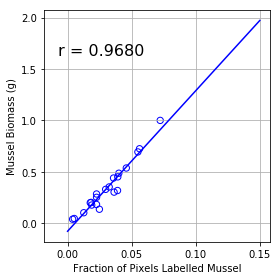

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(pix_ct, y, marker='o', s=40, facecolors='none', edgecolors='b')
ax.set_ylabel('Mussel Biomass (g)')
#ax.set_xlim(0, 1.05)
ax.set_xlabel('Fraction of Pixels Labelled Mussel')

x = np.linspace(0, 0.15)
ax.plot(x, m*x + c, 'b', linestyle='-')
ax.annotate(r'r = %.4f' % r_val, xy=(.06, .805), fontsize=16, xycoords='axes fraction')

ax.grid()
fname = 'TestingSet_Lab_biomass_v_fract_mussel_pixels_v2'

plt.tight_layout()
#fig.savefig(fname + '.png')
#fig.savefig(fname + '.eps', format='eps')